# **HAVOK study** | forcing characterization

**CNN**

*Ref*: [github@baronefr/havok-analysis](github.com/baronefr/havok-analysis)

In this notebook we show a sample of the havok analysis using our **rhavok library**.

In [1]:
from rhavok.havok import havok

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn import metrics

import seaborn

from datetime import datetime

In [2]:
try:
    import cayde_env # importing a custom environment for my server
    cayde_env.tensorflow('CPU')
except: print('no need of custom environment')

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten #, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

 [ CAYDE computing env ]
[tf] CPU set

In [3]:
# color map used in this notebook
this_cm = plt.get_cmap('gist_rainbow')

#### Data import

We import the test dataset from a previously done HAVOK analysis.

In [4]:
data_path = './data/data_havok/'
vv = np.loadtxt(data_path + 'test_v.csv')
tt = np.loadtxt(data_path + 'test_t.csv')
xx = np.loadtxt(data_path + 'test_x.csv')

In [5]:
print(vv.shape[1], 'signatures available')

20 signatures available


### Visualize the embedded coordinates

In [6]:
# plot spectrum of embedded coordinates
def plot_embedded_spectrum(x, t, v,             # data
                  limit, selection = None,      # what to plot
                  vf = lambda x: x,             # transformation function for v
                  figsize = (10,9), alpha = 1): # aesthetics
    
    limit = np.arange(limit[0], limit[1])
    
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[1,2]}, figsize=figsize, sharex=True)
    ax1.plot(t[limit], x[limit], c='k')
    ax1.set_ylabel('x(t)')
    
    if selection is None:
        selection = np.arange(2,v.shape[1]+1)
    elif isinstance(selection, int):
        selection = np.arange(2,selection+1)
    elif isinstance(selection, tuple):
        selection = np.arange(selection[0],selection[1]+1)
    elif isinstance(selection, list):
        pass
    selection = list(selection)
    
    ax2.set_prop_cycle( cycler( color=[this_cm(1.*i/len(selection)) for i in range(len(selection))] ))
    
    for ts in selection:
        ax2.plot(t[limit], vf(v[limit,ts-1]), label=str(ts), alpha=alpha)
    
    ax2.set_ylabel(r"$v_i(t)$")
    ax2.set_ylim([-.021,.021])
    ax2.legend()

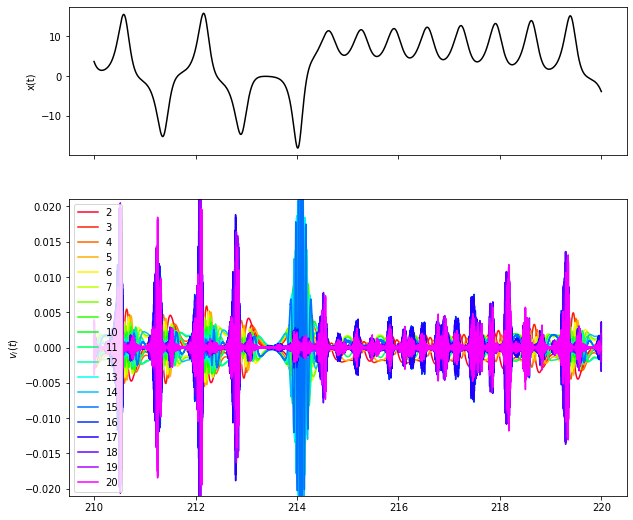

In [7]:
plot_embedded_spectrum(xx, tt, vv, [10000,20000])

<br><br><br>
### Create dataset labels

We wish to isolate the portion of trajectories in which the attractor is going to switch lobe.

In [8]:
# get the index of all sign changes
zero_crosses = np.nonzero(np.diff(xx > 0))[0]

# get the mask of sign changes which have greater stability time
longer = np.append( np.diff(zero_crosses) > 2000, [False])  # these will be class 2

# return only the index values
shorter = np.delete(zero_crosses, longer)
longer = zero_crosses[longer]

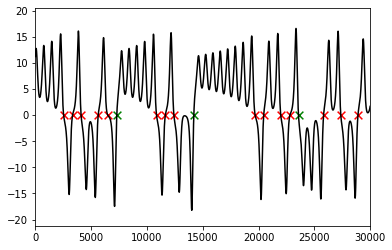

In [9]:
plt.plot(xx, c='k')
plt.scatter(shorter, [0]*len(shorter), marker='x', c='r', s=60)
plt.scatter(longer, [0]*len(longer), marker='x', c='green', s=60)
plt.xlim([0,30000])
plt.show()

In [10]:
selection_window = 700
prediction_margin = 400

In [11]:
candidates = []
for i, diff in enumerate(np.diff(zero_crosses)):
    if diff > 1500:
        left = zero_crosses[i]
        right = zero_crosses[i+1] - selection_window
        while( (right - left) >= selection_window - prediction_margin ):
            candidates.append(right)
            right -= selection_window - prediction_margin
candidates = np.array(candidates)

In [12]:
# mark the window of signal preceding the sign change

labels = np.zeros(len(xx), dtype=int)
labels[ [np.arange(x-(selection_window - prediction_margin),x) for x in candidates] ] = 1
labels[ [np.arange(x-selection_window,x-prediction_margin) for x in shorter] ] = 2
labels[ [np.arange(x-selection_window,x-prediction_margin) for x in longer] ] = 3

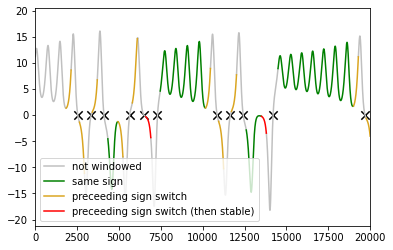

In [13]:
# show me the classes!
rejected = np.ma.masked_where(labels != 0, xx)
normals = np.ma.masked_where(labels != 1, xx)
active1 = np.ma.masked_where(labels != 2, xx)
active2 = np.ma.masked_where(labels != 3, xx)

plt.plot(rejected, lw=1.5, c='silver', label='not windowed')
plt.plot(normals, lw=1.5, c='green', label='same sign')
plt.plot(active1, lw=1.5, c='goldenrod', label='preceeding sign switch')
plt.plot(active2, lw=1.5, c='red', label='preceeding sign switch (then stable)')

plt.scatter(zero_crosses, [0]*len(zero_crosses), marker='x', c = 'k', s=70)
plt.xlim([0,20000])
plt.legend(loc='lower left')
plt.show()

In [14]:
selection_window = selection_window - prediction_margin

In [15]:
slabels = labels - 1
selection = (slabels >= 0)
print(np.sum(selection), 'samples')
print(np.sum(selection)/selection_window, 'windows')

691500 samples
2305.0 windows


Up to now, `slabels` is a vector which stores:
- 0 for stable areas of the attractor
- 1 for areas preceeding a sign switch which lasts a small amount of time
- 2 for areas preceeding a sign switch which lasts a longer amount of time

In [16]:
selected_ranks = [14, 16, 18, 19]

datax = vv[selection]
datax = datax[:,selected_ranks]
datay = slabels[selection]

In [17]:
#datay[ datay == 2 ] = 1

In [18]:
print(datax.shape)
print(datay.shape)

(691500, 4)
(691500,)


In [19]:
datax[abs(datax) > 1] = 1   # make sure nothing is greater than 1

In [20]:
datax

array([[ 1.34498603e-03, -4.39183694e-06, -3.87145887e-05,
         7.37297257e-05],
       [ 1.37094536e-03,  3.11488267e-05,  7.72107003e-06,
        -7.00910795e-05],
       [ 1.37516411e-03, -1.01307499e-05, -3.52817107e-05,
         9.44674477e-05],
       ...,
       [ 4.54679291e-04,  2.33837637e-04,  1.81209470e-03,
         1.37626959e-03],
       [ 1.86434709e-04, -1.92355077e-04, -1.46228978e-03,
        -1.11475267e-03],
       [ 2.55149602e-05,  8.50318681e-05,  1.54875089e-03,
         9.51197501e-04]])

In [21]:
# normalizing data
normalize_coeff = np.max(datax, axis = 0)
print(normalize_coeff)
datax=datax/normalize_coeff

[0.01124196 0.02123125 0.02225983 0.02605928]


In [22]:
N = int(np.sum(selection)/selection_window)
L = selection_window
dim = datax.shape[1]
n_class = 3
print(N, L, dim)

2305 300 4


In [23]:
dataxseq = []
for i in range(N):
    dataxseq.append(datax[(i*selection_window):((i+1)*selection_window)])
dataxseq[-1]

array([[ 0.02107502, -0.003434  , -0.01536129, -0.01285521],
       [ 0.01895351,  0.00563121,  0.01588753,  0.00983732],
       [ 0.01039641,  0.00103342, -0.00993284, -0.00449012],
       ...,
       [ 0.04044483,  0.01101384,  0.08140649,  0.05281303],
       [ 0.01658382, -0.00906   , -0.06569186, -0.04277757],
       [ 0.00226962,  0.00400503,  0.06957604,  0.0365013 ]])

In [24]:
datax[0].shape

(4,)

In [25]:
datax = np.array(dataxseq)
datay = datay[::selection_window]
datay_onehot = np.zeros((N,n_class))
for i in range(N):
    datay_onehot[i][datay[i]] = 1.

In [26]:
print(datax.shape)
print(datay_onehot.shape)

(2305, 300, 4)
(2305, 3)


In [27]:
perc_train = 0.8
N_train = int(perc_train*len(datax))
x_train = datax[:N_train]
y_train = datay_onehot[:N_train]
x_val = datax[N_train:]
y_val = datay_onehot[N_train:]
N_val = len(x_val)

In [28]:
#np.unique(datay, return_counts=True)

<br><br>

### explore dataset

In [29]:
print(x_train.shape)
print(y_train.shape)

(1844, 300, 4)
(1844, 3)


class: [1. 0. 0.]


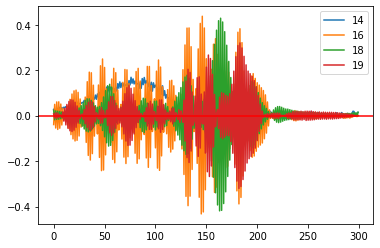

In [30]:
idx = 3

plt.plot(x_train[idx], label = [str(i) for i in selected_ranks])
#plt.xlim([200, 300])
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
print('class:', y_train[idx])

<br><br>

## CNN model

In [31]:
input_shape = (L,dim)


# ...LESSON...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

# from keras import regularizers, initializers

reg = tf.keras.regularizers.l2(0.2)
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

# challenge: at most 600 tunable parameters
model = Sequential()
# 
if NCONV == 1:
    # -----1-----
    model.add(Conv1D(filters=NF,
                     kernel_size=20, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(4,activation='relu'))
    model.add(Dropout(0.05))
# 
if NCONV == 2:
    # -----2-----
    model.add(Conv1D(filters=NF,
                     kernel_size=50, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg, # TRY WITHOUT!
                     activation='relu',
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Flatten())
    model.add(Dense(9,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6,activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(10,activation='relu'))
    #model.add(Dropout(0.3))
model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01,momentum=0.9,nesterov=True) # decay=1e-6
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 281, 5)            405       
                                                                 
 average_pooling1d (AverageP  (None, 56, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 5)             180       
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 4)                 1004      
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                    

2022-06-01 20:04:34.555889: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-06-01 20:04:34.556530: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice


In [32]:
model.layers

#### weight plotting

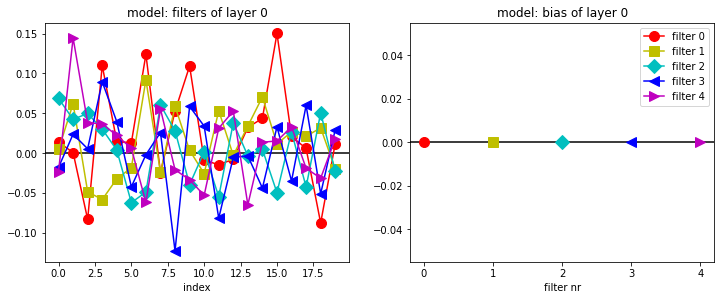

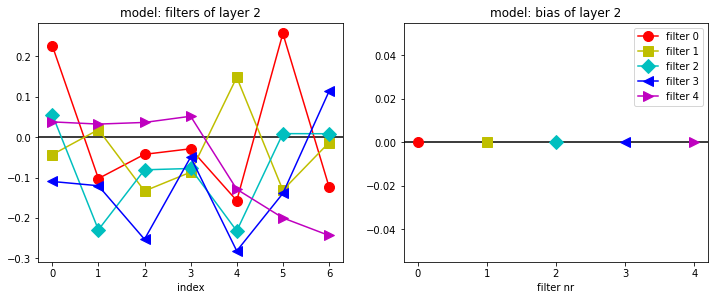

In [33]:
def Show_weights(model,l=0,label="model"):
    c = ['r','y','c','b','m']
    m = ['o','s','D','<','>']
    ms = 10
    
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

### Train CNN 

In [34]:
# Hyper-parameters
BATCH_SIZE = 40
EPOCHS = 500

train_acc,val_acc = [],[]
params = [0]  # try various params?
for pp in params:
    print('----- Model',NCONV,'-----\nFITTING ...')
    
    fit = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('DONE!\n')

----- Model 1 -----
FITTING ...
DONE!



In [35]:
dt_string = datetime.now().strftime("%m-%d_%H-%M")

In [36]:
def Show_history(fit):
    fig,AX = plt.subplots(1,2,figsize=(12,5.))
    ax = AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.legend()
    ax = AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0,1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

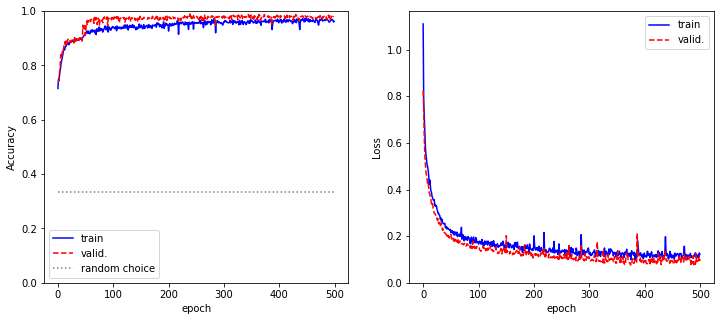

In [37]:
Show_history(fit)

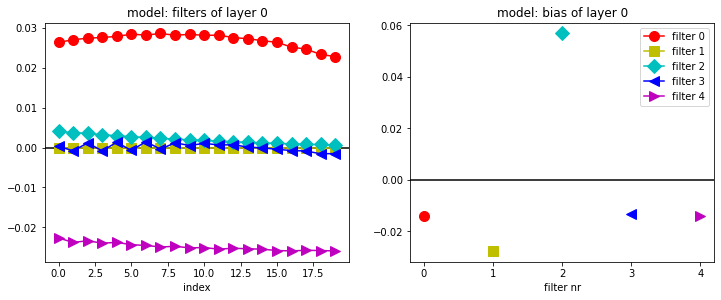

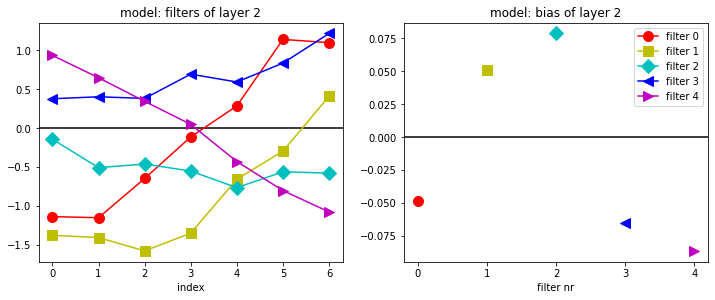

In [38]:
Show_weights(model,0)
Show_weights(model,2)

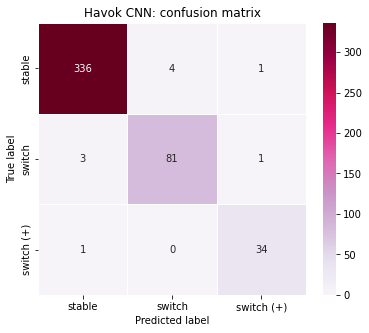

In [39]:
LABELS = ["stable","switch","switch (+)"]
cmap = "PuRd"

def show_confusion_matrix(validations,predictions,label="Havok CNN", save=None):
    matrix = metrics.confusion_matrix(validations,predictions)
    plt.figure(figsize=(6,5))
    seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
    plt.title(label+': confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save is not None:
        plt.savefig(save)
    plt.show()

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val, save = f'./models/cnn_{dt_string}.png')

In [40]:
model.save(f'./models/cnn_{dt_string}.h5')

***

Code by *Francesco Barone*, last review: 1 jun 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.